# Model Training

This Notebook aims to demonstrate the training of the Distance Estimator model. 
<br> We're assuming that the the data that has been processed by the `Object Detector` is available and only **2 cameras** are present.

All trainings are done on a single RTX 3080 GPU.

In [1]:
!nvidia-smi - L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-58d4b761-7fa1-8927-84ca-6f49200bea8f)


In [2]:
import torch.nn as nn
import torch
import tqdm.notebook as tqdm
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import pickle as pkl
from utils.dataset import load_compiled_data

device = torch.device('cuda:0')

# Data Cleaning & Preparation
First all data should be loaded to determine the appropriate `offset`, `divider`, and `trajectory_threshold` values for regularization & false detection removal.
<br> `trajectory_threshold` should be initialized as inifinte to include all detections first. Setting `verbose` to `True` will automatically prints the required data statistics for us.

In [3]:
all_data = load_compiled_data(ts=[1, 2, 3, 4, 5], ws=[1, 2, 3, 4, 5], rs=[
                              1, 2, 3], verbose=True, trajectory_threshold=[np.inf, np.inf])

Data Statistic:

Camera 1:
    Mean    : [600.48486328125, 436.3863830566406, 72.93046569824219, 23.664390563964844]
    Std     : [500.19091796875, 203.197509765625, 37.9368782043457, 15.371478080749512]
    Min     : [19.75390625, 248.5, 9.0, 5.5]
    Min-Max : [1895.24609375, 821.0, 175.25, 151.0]
            
Camera 2:
    Mean    : [625.6908569335938, 378.75115966796875, 50.866493225097656, 17.528425216674805]
    Std     : [503.7662048339844, 74.76707458496094, 23.99972152709961, 10.289787292480469]
    Min     : [5.056640625, 248.5, 10.109375, 4.5]
    Min-Max : [1909.443359375, 708.5, 172.640625, 83.5]
    


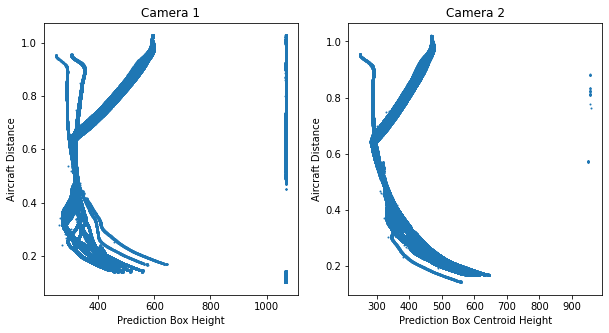

In [4]:
# plot Box Centroid Y against plane distance
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Camera 1")
ax[0].set_xlabel("Prediction Box Height")
ax[0].set_ylabel("Aircraft Distance")
ax[0].scatter(all_data['single']['cam_1']['x'][:, 1].numpy(),
              all_data['single']['cam_1']['y'][:, 0].numpy(), s=1)

ax[1].set_title("Camera 2")
ax[1].set_xlabel("Prediction Box Centroid Height")
ax[1].set_ylabel("Aircraft Distance")
ax[1].scatter(all_data['single']['cam_2']['x'][:, 1].numpy(),
              all_data['single']['cam_2']['y'][:, 0].numpy(), s=1)

From the plot above, it can be determined that true detections is below 800 for camera 1, and below 700 for camera 2.

In [5]:
# hence trajectory threshold can be determined
trajectory_threshold = [800, 700]

In [6]:
# reload data while applying the correct value of trajectory_thresholdm, ensure `verbose = True`
all_data = load_compiled_data(ts=[1, 2, 3, 4, 5], ws=[1, 2, 3, 4, 5], rs=[
                              1, 2, 3], verbose=True, trajectory_threshold=trajectory_threshold)

Data Statistic:

Camera 1:
    Mean    : [568.5925903320312, 382.0452575683594, 71.48180389404297, 23.83118438720703]
    Std     : [508.6205139160156, 86.65821075439453, 38.7922248840332, 15.999728202819824]
    Min     : [19.75390625, 248.5, 9.0, 5.5]
    Min-Max : [1895.24609375, 395.75, 175.25, 151.0]
            
Camera 2:
    Mean    : [625.708740234375, 378.6658020019531, 50.87128829956055, 17.526880264282227]
    Std     : [503.80047607421875, 74.44298553466797, 23.998245239257812, 10.289590835571289]
    Min     : [5.056640625, 248.5, 10.109375, 4.5]
    Min-Max : [1909.443359375, 396.5, 172.640625, 83.5]
    


Offset & divider value can hence be determined

In [7]:
# offset = [offset_camera_1, offset_camera_2]
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]

# divider = [Min-Max_camera_1, divider_camera_2]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]

Reload data with all variables determined and ensure that no false detection is present and data is properly scaled

Data Statistic:

Camera 1:
    Mean    : [0.28958699107170105, 0.33744844794273376, 0.35652950406074524, 0.12139858305454254]
    Std     : [0.2683664858341217, 0.2189721018075943, 0.22135363519191742, 0.1059584692120552]
    Min     : [0.0, 0.0, 0.0, 0.0]
    Min-Max : [1.0, 1.0, 1.0, 1.0]
            
Camera 2:
    Mean    : [0.3250434696674347, 0.32828688621520996, 0.23610851168632507, 0.15601053833961487]
    Std     : [0.2638467848300934, 0.18775026500225067, 0.13900694251060486, 0.12322863936424255]
    Min     : [0.0, 0.0, 0.0, 0.0]
    Min-Max : [1.0, 1.0, 1.0, 1.0]
    


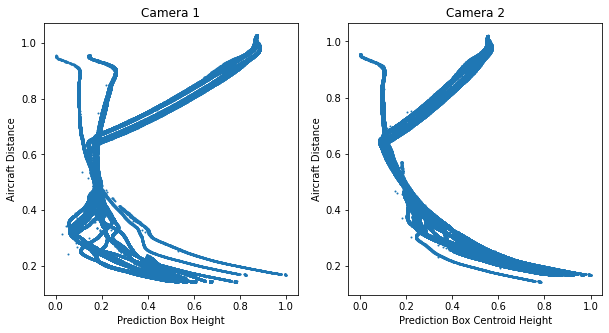

In [8]:
all_data = load_compiled_data(ts=[1, 2, 3, 4, 5], ws=[1, 2, 3, 4, 5], rs=[
                              1, 2, 3], verbose=True, offset=offset, divider=divider, trajectory_threshold=trajectory_threshold)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Camera 1")
ax[0].set_xlabel("Prediction Box Height")
ax[0].set_ylabel("Aircraft Distance")
ax[0].scatter(all_data['single']['cam_1']['x'][:, 1].numpy(),
              all_data['single']['cam_1']['y'][:, 0].numpy(), s=1)

ax[1].set_title("Camera 2")
ax[1].set_xlabel("Prediction Box Centroid Height")
ax[1].set_ylabel("Aircraft Distance")
ax[1].scatter(all_data['single']['cam_2']['x'][:, 1].numpy(),
              all_data['single']['cam_2']['y'][:, 0].numpy(), s=1)

Data has been cleaned and ready for training!

## Training

In [3]:
from torch.utils.data import DataLoader
from utils.head import ensemble
from utils.dataset import load_compiled_data, GeneralDataset
from IPython import display
import tqdm.auto as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random

num_camera = 2
device = torch.device('cuda:0')

In [4]:
# define model:

total_time = 0
model_type = 'm_m'
model = ensemble(f'models/config/model_{model_type}.yaml', device = device)

### Input Regulator
The following process are used to train the `Input Regulator` part of the architecture.

In [11]:
model.input_regs

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
  )
)

Split the dataset. 

`ts=[1,2,5],ws=[1],rs=[1,2]` ~ 6 landings are choosen for training
<br>`ts=[1,2,5],ws=[1],rs=[3]` ~ 3 landings are choosen for testing

Use `offset`, `divider`, and `trajectory_threshold` value determined from previous steps.

In [12]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)

The following hyperparameters can be chosen for training:

In [53]:
t0 = time.time()
optimizers = None
input_reg_training_log = model.training_log['aux']
model.input_regs, model.aux_head, epoch, optimizers, training_log = train_aux(
    input_regs=model.input_regs,
    aux_head=model.aux_head,
    train_data=train_data,
    test_data=test_data, 
    optimizers_algortihm = 'Adam',
    total_epochs=1000,
    loss_scale = 10,
    lr=1e-3
    mode='auto')
total_time += time.time() - t0
model.epochs['aux'] += epoch
model.training_log['aux'] = de_training_log


  1%|1         | 496/40000 [00:02<03:39, 179.85it/s]

Epoch 500
Training Modes: all

Loss:
    Train:
        Cam 1 : 5.8513571275398135e-05
        Cam 2 : 4.4027088733855635e-05
    Test:
        Cam 1 : 4.33945533586666e-05
        Cam 2 : 4.591730976244435e-05

MAPE
    Train:
        Cam 1 : 0.24%
        Cam 2 : 0.19%
    Test:
        Cam 1 : 0.24%
        Cam 2 : 0.21%


Training Modes Available: `'auto'`, `'all'`, `camera n`
- `all` will train all camera in order.
- `0` - `1`will train specific camera. 
- `auto` will intelligently choose which mode to achieve optimal result

Note that Camera is counted from 1, hence `0` will target `Camera 1`.

### Distance Estimator
The following process are used to train the `Distance Estimator` part of the architecture.

In [21]:
model.sequential_de

Sequential(
  (0): LSTM(256, 256, num_layers=2, batch_first=True)
  (1): extract_tensor()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
  (5): ReLU()
)

Split the dataset. 

`ts=[1,2,5],ws=[1],rs=[1,2]` ~ 6 landings are choosen for training
<br>`ts=[1,2,5],ws=[1],rs=[3]` ~ 3 landings are choosen for testing

Use `offset`, `divider`, and `trajectory_threshold` value determined from previous steps.

In [22]:
offset = [[19.75390625, 248.5, 9.0, 5.5], [5.056640625, 248.5, 10.109375, 4.5]]
divider = [[1895.24609375, 395.75, 175.25, 151.0],
           [1909.443359375, 396.5, 172.640625, 83.5]]

trajectory_threshold = [800, 700]

train_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                                1, 2], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)
test_data = load_compiled_data(ts=[1, 2, 5], ws=[1], rs=[
                               3], offset=offset, divider=divider, trajectory_threshold=trajectory_threshold, device=device, verbose=False)

The following hyperparameters can be chosen for training:

In [25]:
t0 = time.time()
optimizers = None
de_training_log = model.training_log['de']
model.input_regs, model.sequential_de, epoch, optimizers, training_log = train_de(
    input_regs=model.input_regs,
    sequential_de=model.sequential_de,
    train_data=train_data,
    test_data=test_data,
    optimizers=optimizers,
    optimizers_algortihm = 'Adam',
    total_epochs=10000,
    loss_scale=10,
    lr=1e-3
    mode='auto')
total_time += time.time() - t0
model.epochs['de'] += epoch
model.training_log['de'] = de_training_log

  0%|          | 5/10000 [00:13<6:13:35,  2.24s/it]

Epoch 5

Loss:
    Train:
        Current : 0.0005435871426016092
        
    Test:
        Deep    : 0.00046186998952180147
        Shallow : 0.0017644953913986683

MAPE 
    Train:
        Current : 1.9685420767981032
    Test:
        Deep    : 1.39%
        Shallow : 1.62%
    Test (Max):
        Deep    : 0.41 nm
        Shallow : 1.34 nm


Training Modes Available: `'auto'`
- `auto` will randomly remove camera views to generalize training.

## Model Saving and Loading

Model can be save using the following code:

In [ ]:
training_dict = {'model_type': model_type,
                 'num_camera': 2,
                 'epochs': model.epochs,
                 'training_log': model.training_log,
                 'state_dict': {'input_reg': model.input_regs.state_dict(),
                                'de': model.sequential_de.state_dict(),
                                'aux': model.aux_head.state_dict()},
                 'training_time': total_time}
torch.save(training_dict, f'models/head/{model_type}.pt')

Model can be loaded using the same `ensemble` function to create them:

In [5]:
model = ensemble(model_conf=f'models/config/model_{model_type}.yaml', 
                 model_state_dict=f'models/head/{model_type}.pt', device = device)